# Face Detection And Recognition

## Loading Dataset

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
from PIL import Image
from keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras import layers , models
from collections import Counter
import pickle
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
__path__ = 'bollywood_celeb_faces_1/'
__train_path__ = __path__
loc = 'data.obj'

In [3]:
cou = 3

In [4]:
X_train , Y_train = [] , []
X_val , Y_val = [] , []

Labels = []

for i in os.listdir(__train_path__) :
    Labels.append(i)

Labels[:cou]

['Irrfan_Khan', 'Jacqueline_Fernandez', 'John_Abraham']

In [5]:
def euclidean_distance(a, b):
    x1 = a[0]; y1 = a[1]
    x2 = b[0]; y2 = b[1]
    return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

## Face Alignment

In [6]:
def face_align(img,gray_img,plot=False) :
    X = None
    try :
        eye_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
        eyes = eye_detector.detectMultiScale(gray_img)
        index = 0
        ### eyes location finding
        for (eye_x, eye_y, eye_w, eye_h) in eyes :
            if index == 0:
                eye_1 = (eye_x, eye_y, eye_w, eye_h) ### eye 1 location
            elif index == 1:
                eye_2 = (eye_x, eye_y, eye_w, eye_h) ### eye 2 location
                break
            index = index + 1
#         if eye_1[0] & eye_2[0] :
#             left_eye = eye_1
#             right_eye = eye_2
#         else:
#             left_eye = eye_2
#             right_eye = eye_1
#             if plot == True :
#                 img_ = cv2.rectangle(gray_img,(eye_x, eye_y),(eye_x+eye_w, eye_y+eye_h), (0,0,0), 2)
#                 plt.imshow(gray_img)
#                 plt.show()

        ### Mid points finding
        eye_1_mid = (eye_1[0]+eye_1[2]//2 , eye_1[1]+eye_1[3]//2) ### eye 1 mid point
        eye_2_mid = (eye_2[0]+eye_2[2]//2 , eye_2[1]+eye_2[3]//2) ### eye 2 mid point

        ### angle finding b/w eye 1 and  eye 2 using triangle

        ### traingle other point finding to form a right angle triangle

        new_point = None
        if eye_1_mid[1] < eye_2_mid[1] :
            new_point = (eye_2_mid[0],eye_1_mid[1]) # eye_1_mid is C
            direction = -1
        elif eye_1_mid[1] > eye_2_mid[1] :
            new_point = (eye_1_mid[0],eye_2_mid[1]) # eye_2_mid is C
            direction = 1
        if plot :
            print(eye_1_mid,eye_2_mid,new_point)
            

        ### angle finding using cosine rule
        ## finding a,b,c if new point is not None

        if new_point is None :
            X = img
        else :
            ### angle finding
            #print(eye_1_mid,eye_2_mid,new_point)
            """
            new_point is A

            """
            a = euclidean_distance(eye_1_mid,eye_2_mid)
            c = euclidean_distance(eye_1_mid,new_point)
            b = euclidean_distance(eye_2_mid,new_point)

            cos_a = (a*a+b*b-c*c)/(2*a*b)
            angle = np.arccos(cos_a)
            angle = (angle * 180) / math.pi
            new_img = Image.fromarray(img)
            if direction == -1 :
                angle = 90 - angle
            if angle <= 10 :
                new_img = np.array(new_img.rotate(direction*angle))
            X = new_img

    except Exception as e :
        #print(e)
        return img

    return X #(X,eye_1_mid,eye_2_mid,new_point)

In [7]:
size=100

## Loading Data with Face Detection

In [8]:
def LoadData(path,size=224) :
    X , Y = [] , []
    c = 0
    for i in os.listdir(path) :
        print(f'\n{i}')
        c += 1
        for j in os.listdir(path + i) :
            print(f'\r\t{j}\t\t{len(X)}\t\t',end="")
            img = cv2.imread(path + i + '/' + j)
            try :
                img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = cv2.equalizeHist(gray)
                FaceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                faces = FaceCascade.detectMultiScale(gray,1.3,5)
                for (x, y, w, h) in faces:
                    face = img[y:y+h,x:x+w]
                    gray = gray[y:y+h,x:x+w]
                    align = face_align(face,gray)
                    img = cv2.resize(align,(size,size))
                    datagen = ImageDataGenerator(horizontal_flip=True)
                    it = datagen.flow(np.expand_dims(img,axis=0), batch_size=1)
                    for l in range(9):
                        #plt.subplot(330 + 1 + l)
                        batch = it.next()
                        image = batch[0].astype('uint8')
                        X.append(image)
                        Y.append(Labels.index(i))
                        #plt.imshow(image)
                    #plt.show()
                    datagen = ImageDataGenerator(rotation_range=10)
                    it = datagen.flow(np.expand_dims(img,axis=0), batch_size=1)
                    for l in range(9):
                        #plt.subplot(330 + 1 + l)
                        batch = it.next()
                        image = batch[0].astype('uint8')
                        X.append(image)
                        Y.append(Labels.index(i))
                        #plt.imshow(image)
                    #plt.show()
                    datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
                    it = datagen.flow(np.expand_dims(img,axis=0), batch_size=1)
                    for l in range(9):
                        #plt.subplot(330 + 1 + l)
                        batch = it.next()
                        image = batch[0].astype('uint8')
                        X.append(image)
                        Y.append(Labels.index(i))
                        #plt.imshow(image)
                    #plt.show()
                    datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
                    it = datagen.flow(np.expand_dims(img,axis=0), batch_size=1)
                    for l in range(9):
                        #plt.subplot(330 + 1 + l)
                        batch = it.next()
                        image = batch[0].astype('uint8')
                        X.append(image)
                        Y.append(Labels.index(i))
                        #plt.imshow(image)
                    #plt.show()
                    break
                    
            except Exception as e:
                #print(e)
                pass
        if c == cou :
            break
    return np.array(X) , np.array(Y)

In [9]:
X_train , Y_train = LoadData(__train_path__,size)
Data = (X_train,Y_train,Labels[:cou])
f = open(loc , 'wb')
pickle.dump(Data , f)


Irrfan_Khan
	99.jpg		2844			
Jacqueline_Fernandez
	99.jpg		4716				
John_Abraham
	99.png		7200			

In [10]:
f = open(loc , 'rb')
X_train,Y_train, Labels = pickle.load(f)

In [11]:
set(Y_train) , len(Y_train)

({0, 1, 2}, 7200)

In [12]:
Counter(Y_train)

Counter({0: 2844, 1: 1908, 2: 2448})

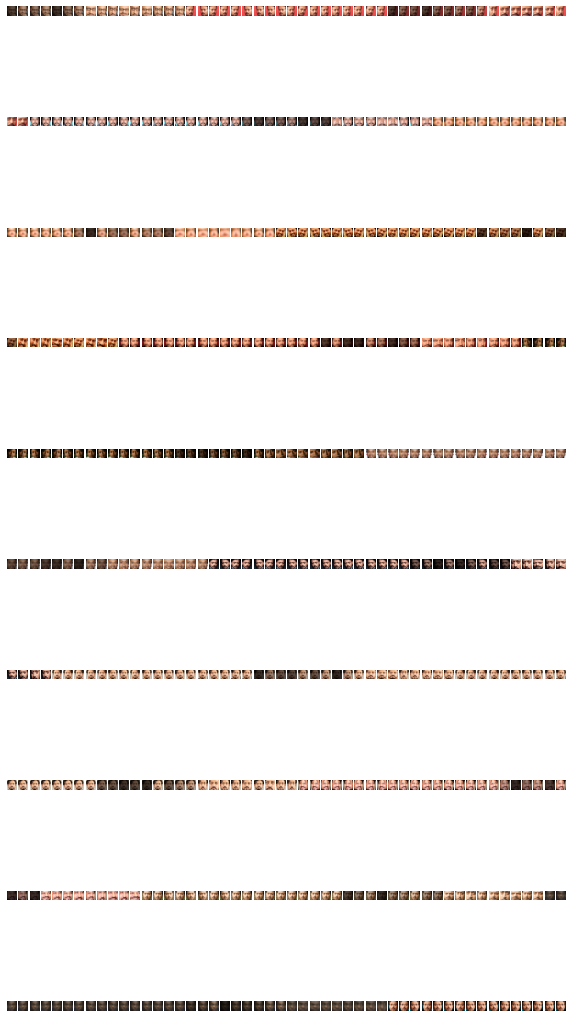

In [13]:
i = 1
plt.figure(figsize=(8,8))
for x,y in zip(X_train[200:700],Y_train[200:700]) :
    plt.subplot(10, 50, i)
    plt.axis('off')
    plt.imshow(x,cmap='gray')
    i += 1
plt.show()

In [14]:
print(f'{X_train.shape},{Y_train.shape}')#,{X_val.shape},{Y_val.shape}')

(7200, 100, 100, 3),(7200,)


In [15]:
X_train = X_train / 255.
#X_val = X_val / 255.

### Model Training 

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32,2,input_shape=X_train[0].shape,activation='relu',padding='SAME'))
model.add(layers.Conv2D(64,2,2,activation='relu',padding='SAME'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,2,activation='relu',padding='SAME'))
model.add(layers.Conv2D(128,2,activation='relu',padding='SAME'))
model.add(layers.MaxPool2D((2,2)))
# model.add(layers.Conv2D(256,2,activation='relu',padding='SAME'))
# model.add(layers.Conv2D(256,2,activation='relu',padding='SAME'))
# model.add(layers.Conv2D(256,2,activation='relu',padding='SAME'))
# model.add(layers.MaxPool2D((2,2)))
# model.add(layers.Conv2D(512,2,activation='relu',padding='SAME'))
# model.add(layers.Conv2D(512,2,activation='relu',padding='SAME'))
# model.add(layers.Conv2D(512,2,activation='relu',padding='SAME'))
# model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(1000,activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(100,activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(len(set(Y_train)),activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       32896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       65664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

In [17]:
epochs = 50
ModelName = 'facedet.h5'
checkpoint = ModelCheckpoint(ModelName, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', sav_freq=5)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
history = model.fit(
    X_train,Y_train,
    #datagen.flow(X_train, Y_train, batch_size=2),
    #validation_data=(X_val,Y_val),
    validation_split = .25 ,
    epochs=epochs,
    shuffle=True,
    callbacks=[checkpoint , early]
)
model.save(ModelName)
model = models.load_model(ModelName)

Epoch 1/50
169/169 [==============================] - 80s 466ms/step - loss: 0.7912 - acc: 0.6417 - val_loss: 1.4773 - val_acc: 0.6272

Epoch 00001: val_loss improved from inf to 1.47735, saving model to facedet.h5
Epoch 2/50
169/169 [==============================] - 74s 435ms/step - loss: 0.1730 - acc: 0.9476 - val_loss: 1.8311 - val_acc: 0.6861

Epoch 00002: val_loss did not improve from 1.47735
Epoch 3/50
169/169 [==============================] - 74s 438ms/step - loss: 0.0900 - acc: 0.9731 - val_loss: 1.8656 - val_acc: 0.5911

Epoch 00003: val_loss did not improve from 1.47735
Epoch 4/50
169/169 [==============================] - 75s 443ms/step - loss: 0.0589 - acc: 0.9814 - val_loss: 2.6686 - val_acc: 0.5883

Epoch 00004: val_loss did not improve from 1.47735
Epoch 5/50
169/169 [==============================] - 74s 438ms/step - loss: 0.0266 - acc: 0.9921 - val_loss: 2.0009 - val_acc: 0.6633

Epoch 00005: val_loss did not improve from 1.47735
Epoch 6/50
169/169 [=================

169/169 [==============================] - 73s 434ms/step - loss: 0.0149 - acc: 0.9977 - val_loss: 6.3185 - val_acc: 0.5761

Epoch 00044: val_loss did not improve from 1.47735
Epoch 45/50
169/169 [==============================] - 74s 437ms/step - loss: 7.1464e-04 - acc: 1.0000 - val_loss: 7.1784 - val_acc: 0.5717

Epoch 00045: val_loss did not improve from 1.47735
Epoch 46/50
169/169 [==============================] - 74s 437ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 6.7440 - val_acc: 0.5544

Epoch 00046: val_loss did not improve from 1.47735
Epoch 47/50
169/169 [==============================] - 74s 439ms/step - loss: 0.0109 - acc: 0.9979 - val_loss: 5.2587 - val_acc: 0.5117

Epoch 00047: val_loss did not improve from 1.47735
Epoch 48/50
169/169 [==============================] - 73s 434ms/step - loss: 0.0137 - acc: 0.9967 - val_loss: 5.9722 - val_acc: 0.5317

Epoch 00048: val_loss did not improve from 1.47735
Epoch 49/50
169/169 [==============================] - 75s 446ms/ste

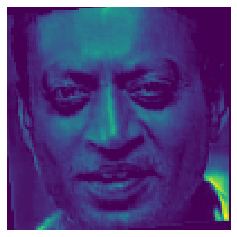

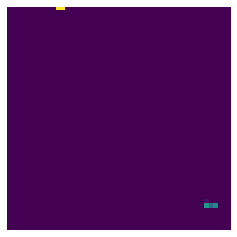

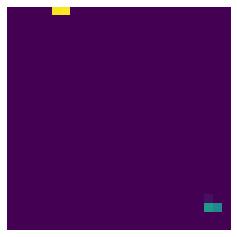

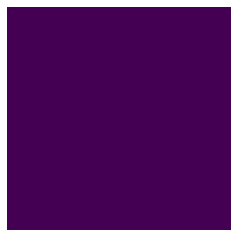

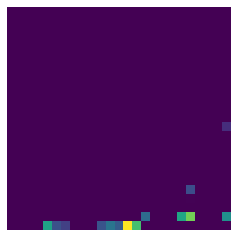

In [18]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(X_train[0],axis=0))

# Getting Activations of first layer
for i in range(5) :
    first_layer_activation = activations[i]

    # shape of first layer activation
#     print(first_layer_activation.shape)

    # 6th channel of the image after first layer of convolution is applied
    plt.matshow(first_layer_activation[0, :, :, 3], cmap ='viridis')
    
    plt.axis('off')

#     # 15th channel of the image after first layer of convolution is applied
#     plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis')
    
#     plt.axis('off')


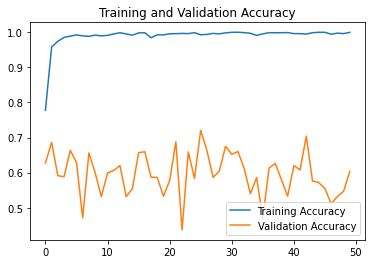

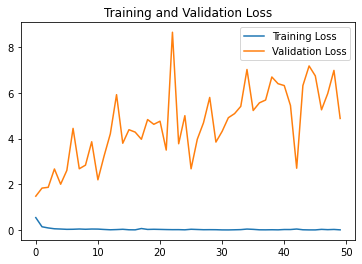

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

In [ ]:
model = models.load_model(ModelName)

In [24]:
def TestImg(path,size=size) :
    X = None
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    try :
        FaceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = FaceCascade.detectMultiScale(gray)
        for (x, y, w, h) in faces:
            img_ = img[y:y+h,x:x+w]
            align = face_align(img_,gray[y:y+h,x:x+w])
            img_ = cv2.resize(align,(size,size))
            X = img_
    except Exception as e:
        X = cv2.resize(img,(size,size))
        print(e)
    X = np.array(X)/255.
    X = np.expand_dims(X,axis=0)
    print(X.shape)
    res = Labels[np.argmax(model.predict(X))]
    return res

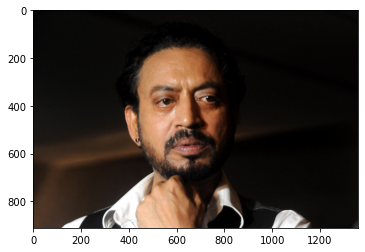

(1, 100, 100, 3)
Irrfan_Khan


In [27]:
print(TestImg('irrfan.jpg'))

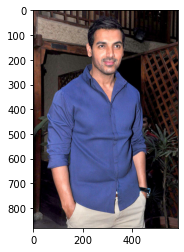

(1, 100, 100, 3)
John_Abraham


In [28]:
print(TestImg('john.jpg'))

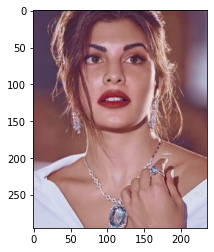

(1, 100, 100, 3)
Jacqueline_Fernandez


In [29]:
print(TestImg('jaq.jpg'))